# Local Histogram Equalization

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Statistics

In [9]:
# Windows are identified by numbers from 0 to end


#calcs the data's mean
def calcMean(data, prob):
    mean = 0
    for i in range(256):
        mean = mean + i*prob[i]
    return mean 

#Gets the Window's data based on Window_number
def getWindowData(data,size, neigh_no):
    height,width = img.shape[:2] 
    many_by_line = width/size
    center_x = int(size//2 + size * (neigh_no // many_by_line))
    center_y = int(size//2 + size * (neigh_no % many_by_line))
    data2 = data[ center_x - size//2:center_x + 1+  size//2 , 
                 center_y - size//2:center_y + 1+  size//2]
    return data2

#Gets the Window's No based on Pixel Coordinates
def getwindowNo(data,size, x, y):
    height,width = data.shape[:2] 
    col = y//size
    line = x//size
    windowsByLine = width //size
    windowsPastLines = line * windowsByLine
    return windowsPastLines + line

#Gets a dictionary with the probability array
def calcProbabilityArray(data):
    height,width = img.shape[:2]
    unique, counts = np.unique(data, return_counts=True) #Pixel Value, Frequency of Pixel Value
    N = height * width # Number of Pixels
    counts = counts / N # Probability of each pixel value.
    dic  = {k:0 for k in range(256)}
    for i in range(len(counts)):
        dic[unique[i]] = counts[i]
    return dic

# Calcs the Nth moment
def calcNthMoment(data, n, mean, prob):
    moment = 0
    for i in range(256):
        moment = moment + prob[i]*(i -mean)**n
    return moment

#Calcs the data's variance
def calcVariance(data, mean, prob):
    return calcNthMoment(data,2, mean, prob)

#Calcs the data's standard deviation
def calcSD(data,  mean, prob):
    return calcVariance(data, mean, prob)**(1/2)

# Returns the new value for a given pixel
def equalizePixel(x,y, data, size):   
    
    global dataLib
    global meanLib
    global probLib
    global sdLib
    global k0,p_g,m_g ,k1,k2,sd_g,E

    windowNo =getwindowNo(data, size, x,y)
    if (windowNo not in dataLib):
        dataLib[windowNo] = getWindowData(data, size, windowNo)
    if (windowNo not in probLib):
        probLib[windowNo] = calcProbabilityArray(dataLib[windowNo])
    if (windowNo not in meanLib):
        meanLib[windowNo] = calcMean(dataLib[windowNo], probLib[windowNo])
    if (windowNo not in sdLib):
        sdLib[windowNo] = calcSD(data, meanLib[windowNo], probLib[windowNo])
    
    # Criteria to decide whether to apply the transformation or not 
    if ( meanLib[windowNo] <= k0 * m_g and
        k1* sd_g <= sdLib[windowNo] and sdLib[windowNo] <= k2* sd_g):
        return E * data[x][y]
    return data[x][y]


In [10]:
N = 5 #Window's size  (NXN)
 
imgfile = '../../db/kidney.tif'
img= cv2.imread(imgfile, 0)
height,width = img.shape[:2]

height = (height//N)*N
width = (width//N)*N

#Image is resized so there are enough pixels to make windows without remainder
img = cv2.resize(img,(width, height))   
img2 = np.zeros((height,width), np.uint8)

In [11]:
#Libs to save computed values, so they're not computed again
meanLib = {} #mean Lib
sdLib = {} # Standard Deviation Lib 
dataLib = {} # Window Data Lib
probLib = {} # Probability Array Lib

In [12]:
#Criteria Constants

k0 = 0.4
p_g = calcProbabilityArray(img)
m_g = calcMean(img, p_g)
k1 = 0.02
k2 = 0.4
sd_g = calcSD(img, m_g, p_g)
E = 0.5

In [13]:
for i in range(height):
    for j in range(width):
        img2[i][j] = equalizePixel(i,j,img,N)

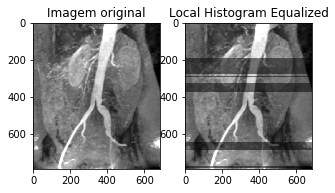

In [14]:
plt.figure(figsize=(5,5))
plt.subplot(121), plt.title("Imagem original"), plt.imshow(img, cmap='gray')
plt.subplot(122), plt.title("Local Histogram Equalized"), plt.imshow(img2, cmap='gray')
plt.show()